In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import math as M
from copy import deepcopy

r_moy = 0.045 # m
delta_r_moy = 0.001 # m
delta_U = 0.5 # V
delta_I = 0.005 # A

df = pd.read_csv("data.csv")
df

,U,I
0,210,1.25
1,150,0.94
2,160,1.03
3,171,1.05
4,181,1.15
5,190,1.17
6,198,1.21
7,220,1.27
8,229,1.31
9,241,1.35


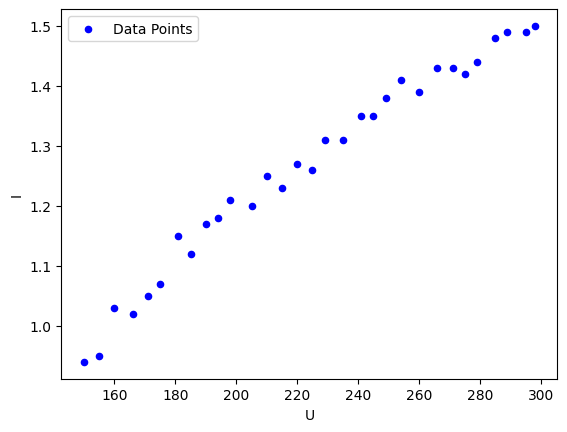

In [2]:
df.plot(x='U', y='I', kind='scatter', color='blue', marker='o', label='Data Points')

plt.show()

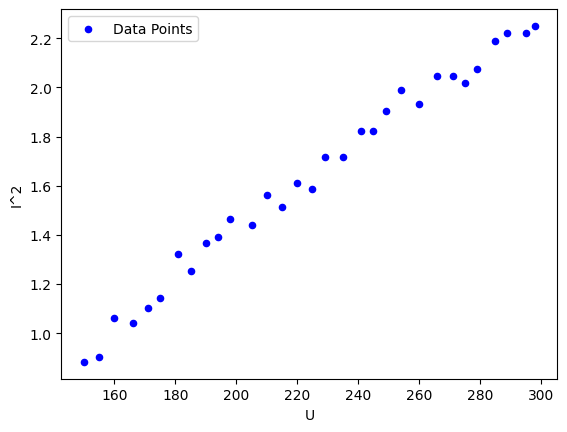

In [3]:
df["I^2"] = df.apply(lambda row:
    row["I"]**2, axis = 1)
df.plot(x='U', y='I^2', kind='scatter', color='blue', marker='o', label='Data Points')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


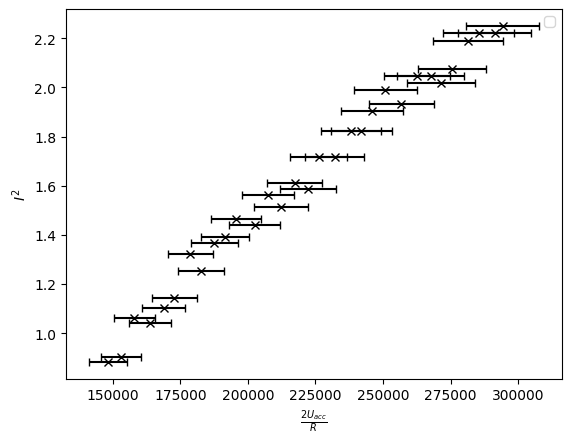

In [4]:
df["2U/R^2"] = df["U"] / r_moy**2 * 2
df["delta(2U/R^2)"] = df.apply(lambda row:
    2 / r_moy**2 * delta_U + 4 * row["U"] / r_moy**3 * delta_r_moy, 
    axis = 1)
df["delta(I)"] = [delta_I] * len(df['I^2'])
df["delta(I^2)"] = df.apply(lambda row:
    2 * row["I"] * row["delta(I)"], 
    axis = 1)

plt.errorbar(df["2U/R^2"], df["I^2"], xerr=df["delta(2U/R^2)"],
             color='black', marker='x', linestyle='None', capsize=3)

# Set plot labels and title
plt.xlabel(r'$\frac{2U_{acc}}{R}$')
plt.ylabel(r"$I^2$")
# titre sur latex
# plt.title(r"rapport des tensions en fonction de $log_{10}(RC)$")
plt.legend()
plt.show()

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            WLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1935.
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           4.22e-28
Time:                        13:20:25   Log-Likelihood:                 47.852
No. Observations:                  31   AIC:                            -91.70
Df Residuals:                      29   BIC:                            -88.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4591      0.046     -9.996      0.0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


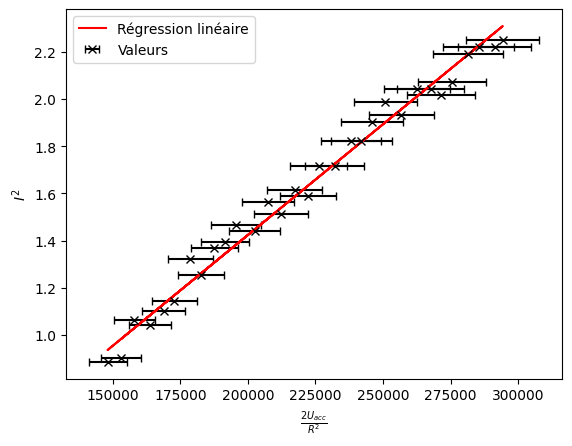

In [16]:
X = df['2U/R^2'].values
Y = df['I^2'].values
X_uncertainty = df['delta(2U/R^2)'].values
Y_uncertainty = df['delta(I^2)'].values

X_with_intercept = sm.add_constant(X)  # Add a constant term (intercept) to the X values

# Weighted least squares regression
model = sm.WLS(Y, X_with_intercept, weights=1 / Y_uncertainty**2)
results = model.fit()

# Print the regression summary
print(results.summary())

slope = results.params[1]
intercept = results.params[0]

standard_errors = results.bse

# The standard error for the slope (coefficient of X) is typically the second element in the standard_errors array
slope_standard_error = standard_errors[1]

print("Slope", slope)
print("Standard Error of the Slope:", slope_standard_error)

predicted_Y = results.predict(X_with_intercept)
plt.errorbar(X, Y, xerr=X_uncertainty, #yerr=Y_uncertainty, #est négligeable
          color='black', marker='x', linestyle='None', label="Valeurs", capsize=3)
plt.plot(X, predicted_Y, color='red', label='Régression linéaire')

# Set plot labels and title
plt.xlabel(r'$\frac{2U_{acc}}{R^2}$') #[$\Omega F$] pas d'unités je crois
plt.ylabel(r"$I^2$")
# titre sur latex
# plt.title(r"qqch")
plt.legend()
plt.savefig('graph.eps')
plt.show()

In [6]:
df

,U,I,I^2,2U/R^2,delta(2U/R^2),delta(I),delta(I^2)
0,210,1.25,1.5625,207407.407407,9711.934156,0.005,0.0125
1,150,0.94,0.8836,148148.148148,7078.189300,0.005,0.0094
2,160,1.03,1.0609,158024.691358,7517.146776,0.005,0.0103
3,171,1.05,1.1025,168888.888889,8000.000000,0.005,0.0105
4,181,1.15,1.3225,178765.432099,8438.957476,0.005,0.0115
5,190,1.17,1.3689,187654.320988,8834.019204,0.005,0.0117
6,198,1.21,1.4641,195555.555556,9185.185185,0.005,0.0121
7,220,1.27,1.6129,217283.950617,10150.891632,0.005,0.0127
8,229,1.31,1.7161,226172.839506,10545.953361,0.005,0.0131
9,241,1.35,1.8225,238024.691358,11072.702332,0.005,0.0135


In [10]:
df["S(I^2)"] = df["delta(I^2)"] / df["I^2"]
df["S(2U/R^2)"] = df["delta(2U/R^2)"] / df["2U/R^2"]
df

,U,I,I^2,2U/R^2,delta(2U/R^2),delta(I),delta(I^2),S(I^2),S(2U/R^2)
0,210,1.25,1.5625,207407.407407,9711.934156,0.005,0.0125,0.008000,0.046825
1,150,0.94,0.8836,148148.148148,7078.189300,0.005,0.0094,0.010638,0.047778
2,160,1.03,1.0609,158024.691358,7517.146776,0.005,0.0103,0.009709,0.047569
3,171,1.05,1.1025,168888.888889,8000.000000,0.005,0.0105,0.009524,0.047368
4,181,1.15,1.3225,178765.432099,8438.957476,0.005,0.0115,0.008696,0.047207
5,190,1.17,1.3689,187654.320988,8834.019204,0.005,0.0117,0.008547,0.047076
6,198,1.21,1.4641,195555.555556,9185.185185,0.005,0.0121,0.008264,0.046970
7,220,1.27,1.6129,217283.950617,10150.891632,0.005,0.0127,0.007874,0.046717
8,229,1.31,1.7161,226172.839506,10545.953361,0.005,0.0131,0.007634,0.046628
9,241,1.35,1.8225,238024.691358,11072.702332,0.005,0.0135,0.007407,0.046519


In [15]:
latex_code1 = df.to_latex(index=True, escape=False, 
    columns = ["U", "I", "I^2", "2U/R^2", "S(I^2)", ], formatters={
    "I" : (lambda v: f'{v:1.2f}'),
    "I^2" : (lambda v: f'{v:1.2f}'),
    "2U/R^2" : (lambda v: f'{v:1.2e}'),
    "S(I^2)" : (lambda v: f'{v:1.1e}'),
    })
print(latex_code1)

\begin{tabular}{lrrrrr}
\toprule
 & U & I & I^2 & 2U/R^2 & S(I^2) \\
\midrule
0 & 210 & 1.25 & 1.56 & 2.07e+05 & 8.0e-03 \\
1 & 150 & 0.94 & 0.88 & 1.48e+05 & 1.1e-02 \\
2 & 160 & 1.03 & 1.06 & 1.58e+05 & 9.7e-03 \\
3 & 171 & 1.05 & 1.10 & 1.69e+05 & 9.5e-03 \\
4 & 181 & 1.15 & 1.32 & 1.79e+05 & 8.7e-03 \\
5 & 190 & 1.17 & 1.37 & 1.88e+05 & 8.5e-03 \\
6 & 198 & 1.21 & 1.46 & 1.96e+05 & 8.3e-03 \\
7 & 220 & 1.27 & 1.61 & 2.17e+05 & 7.9e-03 \\
8 & 229 & 1.31 & 1.72 & 2.26e+05 & 7.6e-03 \\
9 & 241 & 1.35 & 1.82 & 2.38e+05 & 7.4e-03 \\
10 & 249 & 1.38 & 1.90 & 2.46e+05 & 7.2e-03 \\
11 & 260 & 1.39 & 1.93 & 2.57e+05 & 7.2e-03 \\
12 & 271 & 1.43 & 2.04 & 2.68e+05 & 7.0e-03 \\
13 & 279 & 1.44 & 2.07 & 2.76e+05 & 6.9e-03 \\
14 & 289 & 1.49 & 2.22 & 2.85e+05 & 6.7e-03 \\
15 & 298 & 1.50 & 2.25 & 2.94e+05 & 6.7e-03 \\
16 & 155 & 0.95 & 0.90 & 1.53e+05 & 1.1e-02 \\
17 & 166 & 1.02 & 1.04 & 1.64e+05 & 9.8e-03 \\
18 & 175 & 1.07 & 1.14 & 1.73e+05 & 9.3e-03 \\
19 & 185 & 1.12 & 1.25 & 1.83e+05 & 8.9

In [7]:
# Create a new column 'original_index' to store the original index


# Calculate the number of rows in each smaller DataFrame
rows_per_df = 11
cuts = 3

for i in range(cuts):
    new_df = pd.DataFrame()
    start = i * rows_per_df + 1
    end = start + rows_per_df
    end = rows_per_df * cuts - 1 if end > rows_per_df * cuts - 1 else end
    for column_name, column_values in df.items():
        new_df[column_name] = df[column_name][start:end+1].copy()
    print(new_df)

      U     I     I^2         2U/R^2  delta(2U/R^2)  delta(I)  delta(I^2)
1   150  0.94  0.8836  148148.148148    7078.189300     0.005      0.0094
2   160  1.03  1.0609  158024.691358    7517.146776     0.005      0.0103
3   171  1.05  1.1025  168888.888889    8000.000000     0.005      0.0105
4   181  1.15  1.3225  178765.432099    8438.957476     0.005      0.0115
5   190  1.17  1.3689  187654.320988    8834.019204     0.005      0.0117
6   198  1.21  1.4641  195555.555556    9185.185185     0.005      0.0121
7   220  1.27  1.6129  217283.950617   10150.891632     0.005      0.0127
8   229  1.31  1.7161  226172.839506   10545.953361     0.005      0.0131
9   241  1.35  1.8225  238024.691358   11072.702332     0.005      0.0135
10  249  1.38  1.9044  245925.925926   11423.868313     0.005      0.0138
11  260  1.39  1.9321  256790.123457   11906.721536     0.005      0.0139
12  271  1.43  2.0449  267654.320988   12389.574760     0.005      0.0143
      U     I     I^2         2U/R^2  